# Spotify recommendation using MinHashing and Gaussian Mixture Models

## Group Members: Kaile Suoo, Jerry Li, Tawhid Ather

## Description

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.sparse import csr_matrix
import statsmodels.api as sm
from itertools import combinations
import json

## Dataset

### Spotify Million Playlists

Resources: 

- https://research.atspotify.com/2020/09/the-million-playlist-dataset-remastered/

- https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge

In [2]:
# only read in necessary features from dataset and put into dataframe
playlists = []
for i in range(0, 1000000, 1000):
    with open(f'./data/data/mpd.slice.{i}-{i+999}.json', 'r') as file:
        data = json.load(file)
        
        for playlist in data['playlists']:
            playlists.append({
                'pid': playlist['pid'],
                'name': playlist['name'],
                'tracks': [track['track_uri'] for track in playlist['tracks']], 
            })
df = pd.DataFrame(playlists)

In [3]:
df

,pid,name,tracks
0,0,Throwbacks,"[spotify:track:0UaMYEvWZi0ZqiDOoHU3YI, spotify..."
1,1,Awesome Playlist,"[spotify:track:2HHtWyy5CgaQbC7XSoOb0e, spotify..."
2,2,korean,"[spotify:track:74tqql9zP6JjF5hjkHHUXp, spotify..."
3,3,mat,"[spotify:track:4WJ7UMD4i6DOPzyXU5pZSz, spotify..."
4,4,90s,"[spotify:track:4iCGSi1RonREsPtfEKYj5b, spotify..."
...,...,...,...
999995,999995,Praise,"[spotify:track:2AMSWGnT7NCvOAPXxuRxIh, spotify..."
999996,999996,Worship,"[spotify:track:2vr3TRf7tH7dfrUp9noq5u, spotify..."
999997,999997,Sex,"[spotify:track:1sQrCwV8vvtYLqa0KQlwE9, spotify..."
999998,999998,✝️,"[spotify:track:5Mw9bXG1dLNhbjofkVS2oR, spotify..."


In [4]:
# mapping indices to values and vice versa for later use 
unique_tracks = set()
for tracks in df['tracks']:
    unique_tracks.update(tracks)

track_idx = {}
idx_track = {}
for idx, track in enumerate(unique_tracks):
    track_idx[track] = idx
    idx_track[idx] = track

playlist_idx = {}
idx_playlist = {}
for idx, playlist in enumerate(df['pid']):
    playlist_idx[playlist] = idx
    idx_playlist[idx] = playlist

n_playlists = len(df)
n_tracks = len(unique_tracks)

n_tracks, n_playlists

(2262292, 1000000)

### Audio Features

From datasets before this Spotify Web API was deprecated and removed access to audio features. Combined to create dataset with track uris and their audio features.

Resources: 

- tracks_features.csv by [Rodolfo Figueroa](https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs/code)

- Final Dataset.csv by [Arman Mehdi](https://github.com/ArmanMehdi/Music-mood-predictor/blob/main/Final%20Dataset.csv)

- Dataset.csv by [Maharshipandya](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/tree/main)

- SpotifyFeatures.csv by [Zaheen Hamidani](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db)

- genres_v2.csv by [Andrii Samoshyn](https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotify?select=genres_v2.csv)

- spotify_data.csv by [Amitansh Joshi · Amit Parolkar · Vedant Das](https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks?select=spotify_data.csv)

- tracks.csv by [Yamac Eren Ay](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv)

- spotify_dataset.csv by [Blurridge](https://github.com/blurridge/spotify-dataset-generator/blob/main/spotify_dataset.csv)

- Spotify_Song_Attributes.csv by [Byomokesh Senapati](https://www.kaggle.com/datasets/byomokeshsenapati/spotify-song-attributes)

- data.csv by [Gabminamedez](https://raw.githubusercontent.com/gabminamedez/spotify-data/refs/heads/master/data.csv)

In [ ]:
# read in all datasets
tracks1 = pd.read_csv('./data/Final Dataset.csv')
tracks1.rename(columns={'artist': 'artists'}, inplace=True)

tracks2 = pd.read_csv('./data/tracks_features.csv')

tracks3 = pd.read_csv('./data/dataset.csv')
tracks3.rename(columns={'track_id': 'id', 'track_name': 'name'}, inplace=True)

tracks4 = pd.read_csv('./data/SpotifyFeatures.csv')
tracks4.rename(columns={'track_id': 'id', 'track_name': 'name', 'artist_name': 'artists'}, inplace=True)

tracks5 = pd.read_csv('./data/genres_v2.csv')
tracks5.rename(columns={'song_name': 'name'}, inplace=True)
tracks5['artists'] = 'N/A'

tracks6 = pd.read_csv('./data/spotify_data.csv')
tracks6.rename(columns={'track_id': 'id', 'track_name': 'name', 'artist_name': 'artists'}, inplace=True)

tracks7 = pd.read_csv('./data/tracks.csv')

tracks8 = pd.read_csv('./data/spotify_dataset.csv')
tracks8.rename(columns={'spotify_song_id': 'id', 'title': 'name', 'artist': 'artists'}, inplace=True)

tracks9 = pd.read_csv('./data/Spotify_Song_Attributes.csv')
tracks9.rename(columns={'trackName': 'name', 'artistName': 'artists'}, inplace=True)

tracks10 = pd.read_csv('./data/data.csv')

In [ ]:
# combine
all_tracks = pd.concat([tracks1, tracks2, tracks3, tracks4, tracks6, tracks7, tracks8, tracks9, tracks10, tracks5], ignore_index=True)
all_tracks = all_tracks.drop_duplicates(subset=['id'])
all_tracks.reset_index(inplace=True)
all_tracks.columns

In [ ]:
# only keep audio features
drop = ['loudness','tempo','key','mode','instrumentalness', 'duration_ms', 'time_signature','index','genres','Unnamed: 0.1','uri', 'Unnamed: 0', 'id_artists','type', 'track_href','analysis_url','error', 'popularity', 'album', 'album_id','artist_ids', 'track_number', 'disc_number', 'explicit', 'year','release_date', 'album_name', 'track_genre', 'genre', 'title', 'spotify_artist_id', 'release_date_precision', 'track_popularity', 'artist_popularity', 'msPlayed']
filtered_tracks = all_tracks.drop(columns = drop)
filtered_tracks = filtered_tracks.dropna()
filtered_tracks

In [ ]:
# exported for faster use later
all_tracks.to_csv('tracks_data.csv', index=False)

In [5]:
# audio features for the tracks 
tracks_data = pd.read_csv('./data/tracks_data.csv')
tracks_data

,id,name,artists,danceability,energy,speechiness,acousticness,liveness,valence
0,5tq3Ygbw8ReO3pkehrmdFH,Cumbias del pasado,Victor Bernal,0.520,0.989,0.0687,0.31900,0.125,0.684
1,3XGY5swlPLOmdSuMeuGxol,Babo Barish Kar De Paiso Ki,Raju Punjabi,0.850,0.807,0.0465,0.02640,0.167,0.590
2,3q2cfRnoHTAhiWJgIxQvqA,Asharuwa,Mynmaster productions,0.737,0.729,0.3810,0.93300,0.329,0.940
3,0O9RWQNpRlEcAaf3IEegbY,Limeryki dla odmladzajacych sie,Halina Kunicka,0.426,0.494,0.0977,0.58000,0.258,0.867
4,1djC0yUlRIfEYKlsYDod2V,Okefenokee,Doc Severinsen,0.669,0.732,0.0623,0.47100,0.620,0.814
...,...,...,...,...,...,...,...,...,...
2984439,5zEoohLO20ofIBg0fzPqhQ,Get $ Paid,NaN,0.812,0.658,0.1570,0.00607,0.134,0.514
2984440,6Nv73zhgxCrWigqzGWCfNA,I'm Sorry Baby (Remix) [feat. Wadz & Talkbox P...,NaN,0.719,0.444,0.1900,0.05440,0.170,0.724
2984441,54v6Kv41W8AKToCb14PmJD,"H20 (feat. Pharoahe Monch, Rakaa Iriscience, &...",NaN,0.526,0.819,0.2980,0.00206,0.336,0.581
2984442,4YuGxSdxyL6fRD7uchn9dI,Daddy's Girl,NaN,0.538,0.819,0.4670,0.00854,0.131,0.252


## MinHashing

Find the k-most similar playlists to any given playlist.

Estimate Jaccard Similarity between the million playlists to find the ones most similar to each other.

Resources:

- Class version of minhash algorithm

- https://www.geeksforgeeks.org/how-to-create-a-sparse-matrix-in-python/#

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html



In [6]:
# Used to check minhasing approximations
def jaccard_similarity(playlist1, playlist2):
  set1 = set(playlist1)
  set2 = set(playlist2)
  intersection = len(set1.intersection(set2))
  union = len(set1) + len(set2) - intersection
  return intersection / union

In [7]:
# original method was inefficient for memory, construct sparse characteristic matrix
row = []
col = []
data = []

for idx, tracks in enumerate(df['tracks']):
    for track in tracks:
        row.append(track_idx[track])
        col.append(idx)
        data.append(1)

dfC = csr_matrix((data, (row, col)), shape=(len(unique_tracks), len(df)))

In [8]:
def minhash(nhash, dfC, Phash): 
    '''
    Takes a number of hash functions to use (nhash) and characteristic matrix (dfC)
    '''
    # use the "universal hash":  (a*x+b) mod p, where a, b are random ints and p > N is prime
    np.random.seed(4022)
    
    Phash = Phash 
    Ahash = np.random.choice(range(0, Phash), size=nhash)
    Bhash = np.random.choice(range(0, Phash), size=nhash)

    # STEP 2:  initialize signature matrix to all infinities
    Msig = np.full([nhash, dfC.shape[1]], fill_value=np.inf)

    # fill in the signature matrix:
    # For each row of the characteristic matrix... 
    hash_vals = [0]*nhash # initialize
    for r in range(dfC.shape[0]):
        # STEP 3:  Compute hash values (~permuted row numbers) for that row under each hash function
        hash_vals = (Ahash * r + Bhash) % Phash
        # STEP 4:  For each column, if there is a 0, do nothing...
            # ... but if there is a 1, replace signature matrix element in that column for each hash fcn 
            # with the minimum of the hash value in this row, and the current signature matrix element
        c = dfC[r].nonzero()[1]
        for h in range(nhash):
            Msig[h, c] = np.minimum(Msig[h, c], hash_vals[h])
    return Msig

In [9]:
nhash = 100
Phash = 2500009

Msig = minhash(nhash, dfC, Phash)

In [10]:
# computing entire similarity matrix is computationally expensive, so only compute for the playlist we're interested in making recommendations for
def get_k_similar_playlists(Msig, playlist_idx, k):
    sims = []
    for i in range(Msig.shape[1]):
        if i == playlist_idx:
            sims.append(0) # exclude itself from sims
        else:
            sims.append(np.sum(Msig[:, playlist_idx] == Msig[:, i]) / nhash)

    # get k most similar
    similar = {}
    for i in range(k):
        temp = np.argmax(sims)
        similar[temp] = sims[temp]
        sims[temp] = 0

    return similar

In [30]:
# example for if we wanted to find the 20 most similar songs to the playlist at index 0
input_playlist_idx = 0
k = 20
similar = get_k_similar_playlists(Msig, input_playlist_idx, k)

print(k, 'most similar to', df.iloc[input_playlist_idx]['name'])
for idx, sim in similar.items():
    print(df.iloc[idx]['name'], ':', sim)

20 most similar to Throwbacks
throwback : 0.3
Early 2000s : 0.24
bangers : 0.23
Oldies : 0.23
throwbacks : 0.22
2000s : 0.21
tbt : 0.21
tbt : 0.21
childhood : 0.21
THROWBACKS : 0.2
tbt : 0.2
Throwbacks : 0.2
carpool : 0.2
Throwback jams : 0.19
teen angst : 0.19
tbt : 0.19
classic  : 0.19
tbt : 0.19
2000s : 0.19
tb : 0.19


## Gaussian Mixture Models (GMM)

Cluster songs within the k most similar playlists and recommend based on probabilities.

#### Principal Component Analysis (PCA)

Reduce the dimensions of audio features for clustering.

Resources:
- Class version of GMM algorithm
- https://www.geeksforgeeks.org/principal-component-analysis-pca/#

In [31]:
# remove duplicates from the similar playlists and get audio features from songs in the dataset
def process_similar_playlists(similar, idx):
    track_ids = set()
    for playlist_idx in similar:
        for track in playlists[playlist_idx]['tracks']:
            filtered = track.replace('spotify:track:', '')
            track_ids.add(filtered)

    dat = tracks_data[tracks_data['id'].isin(track_ids)]
    dat.reset_index(drop=True, inplace=True)

    # save songs in the original playlist
    input_songs_indices = set()
    for song in playlists[idx]['tracks']:
        filtered = song.replace('spotify:track:', '')
        if filtered in dat.values:
            index = dat.index[dat['id'] == filtered]
            input_songs_indices.add(index[0])
    
    return dat, input_songs_indices

In [32]:
dat, input_songs_indices = process_similar_playlists(similar, idx) 

GMM_DROP = ['id', 'name', 'artists']
dat1 = dat.drop(columns=GMM_DROP)
dat1 # audio features for the songs in similar playlists for Throwbacks

,danceability,energy,speechiness,acousticness,liveness,valence
0,0.481,0.940,0.0660,0.000891,0.0939,0.660
1,0.751,0.937,0.1080,0.012200,0.0639,0.662
2,0.847,0.843,0.1060,0.415000,0.1070,0.963
3,0.778,0.824,0.0712,0.284000,0.4050,0.756
4,0.380,0.988,0.0639,0.000026,0.3680,0.769
...,...,...,...,...,...,...
428,0.743,0.766,0.0265,0.087300,0.5090,0.610
429,0.657,0.588,0.0272,0.025200,0.0870,0.105
430,0.853,0.606,0.0713,0.056100,0.3130,0.654
431,0.499,0.880,0.3950,0.006840,0.0991,0.461


In [33]:
def GMM(dat, k, dimension):
    
    #Comments will reference slides 26-31 from Feb 9:
    
    """Define the variables we will use in the Algorithm"""
    #This represents W_m (weights/likelihood of each component) (slide 26)
    p_class=np.zeros(k)
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,dimension))
    
    #This represents Σ_m (covariance matrix) (slide 26)
    covars=np.zeros((k,dimension,dimension))
    
    #This represets p̃_mi (slide 27)
    p_data_given_class=np.zeros((len(dat),k))

    #This is just used at the end to compute mean dist
    mean_dist=np.array(0)
    
    #initializations of initial points (used to set the initial menas lower down)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    #print("INIT_IDX: {}".format(init_idx))
    
    """Initialize means, covs, p_classes"""
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k    
    
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    for step in range(50):  
        """Expectation Step (Slide 27)"""
        #Bayes stuff: pdfs then pdf*mixtures, then normalize
        
        #For each class (component), compute prob data given class slide 27)
        for dim in range(k):
            #Use pdf to get prob of each data point given component (dim) (slide 27)
            p_data_given_class[:,dim] = stats.multivariate_normal.pdf(x=dat, mean=means[dim], cov=covars[dim])
            #What we have now is P(x_i | cluster = m). We still need to multiply by P(cluster = m)
            
        #Multiply by p_class (slide 27)
        p_class_given_data=p_data_given_class*p_class

        #Now consolidate into probabilities using 1/α_i (slide 27)
        sums=np.sum(p_class_given_data, axis=1)

        for dim in range(k):
            #For each class, divide by the sum to convert to probabilities (slide 27)
            #p_class_given_data now represents p̂_mi
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
            
        #Now we have completed everything in the Expectation step (slide 27). We'll move on to the maximization step

        """Maximization Step (Slide 29-30)"""
        #We'll count the number of points in each component (will be fractional, not whole #)
        #n_class represents n̂_m (Slide 30)
        n_class = np.sum(p_class_given_data, axis=0)

        #Now, we re-compute p_class (which represents W_m, or the weight/likelihood of each class)
        #(See first bullet pt on slide 30)
        p_class=n_class/len(dat)

        #Now we need to do the mean and covariance updates (slide 30)
        for dim in range(k):
            #To compute new means within each class/component (slide 30 bullet pt. 2)
            #1. Sum across: (p_class_given_data * data) = (p̂_mi * x_i)
            #2. Divide by n_class (n̂_m)
            for i in range(dimension):
                means[dim, i] = np.sum(p_class_given_data[:, dim] * dat.iloc[:, i]) / n_class[dim]
            
            #Now we update the variance/covariance Σ_m by weighted sample covariance (slide 30 bullet pt. 3)
            #Make a copy of the data, then subtract the new means
            X_new=dat.copy()
            X_new = dat - means[dim]
                        
            #We can compute the covar matrix for each component as below (slide 30 bullet pt. 3):
            #1. First we'll take the transpose of our new "centered" data (X_new)
            #2. Then we multiply that by our p_class_given_data (p̂_mi)
            #3. Next we do a matrix multiplication between our result from step 2 and X_new (mean centered data)
            #4. Last, we divide by n_class (n̂_m)
            
            covars[dim,:,:]=np.matmul((np.asarray(X_new).T)*(p_class_given_data[:,dim]),X_new)/(n_class[dim])                                                    

    #Once we're done with our for loop, we compute the mean dist (This formula is given below in Part B):
    mean_dist=0
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart 
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
  
    mean_dist=mean_dist/(len(dat)*k)
    #Return all the needed variables
    return p_class_given_data, means, covars, p_class, mean_dist

In [34]:
# pca to reduce dimensions of each song's audio features to 2
def PCA(m, k):
    # build m^t m since smaller
    m_new = (m - m.mean()) / m.std()
    mtm = (np.transpose(m_new) @ m_new) / (m.shape[0] - 1)

    eigenvalues, eigenvectors = np.linalg.eig(mtm)

    # construct matrix e from eigenvectors corresponding to highest eigenvalues
    e_columns = []
    for i in range(k):
        idx = np.argmax(eigenvalues)
        e_columns.append(idx)
        eigenvalues[idx] = 0
    
    e = eigenvectors[:, e_columns]
    return m @ e

dat2 = PCA(dat1, 2)

Text(0.5, 1.0, 'Mean Distance for k clusters')

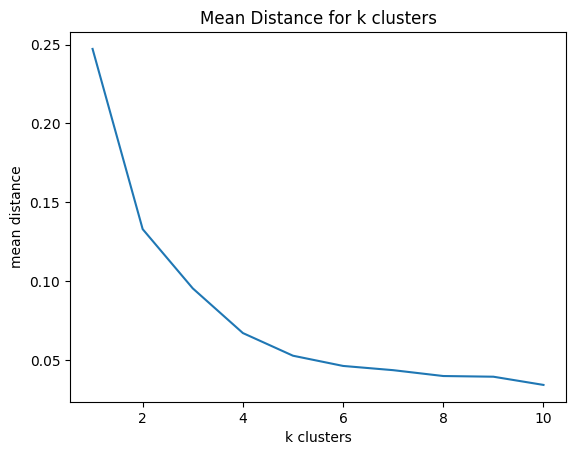

In [35]:
# find best number of clusters (elbow)
ks = [1,2,3,4,5,6,7,8,9,10]
mean_distances = []

for k in ks:
    p_class_given_data, means, covars, p_class, mean_dist = GMM(dat2, k, dat2.shape[1])
    mean_distances.append(mean_dist)

plt.plot(ks, mean_distances)
plt.xlabel('k clusters')
plt.ylabel('mean distance')
plt.title('Mean Distance for k clusters')

The elbow is around k = 5,6, so this many clusters would work well.

In [38]:
# get songs to recommend
def get_top_k_songs(k, pmi, dat, input_song_indices):
    copy_pmi = pmi.copy()
    
    recommendations = []
    probabilities = []

    cluster = 0
    num_clusters = len(copy_pmi[0]) - 1

    while len(recommendations) < k:
        
        # go through clusters and get most probable song from each cluster
        if cluster == num_clusters:
            cluster = 0

        highest_indices_from_cluster = np.argmax(copy_pmi, axis=0)

        index = highest_indices_from_cluster[cluster]

        # skip recommendations if they already exist in the input playlist
        if index not in input_song_indices:
            recommendations.append(index)
            probabilities.append((copy_pmi[index][cluster], cluster))
        copy_pmi[index][cluster] = 0
        cluster += 1

    most_probable_songs = dat.iloc[recommendations].copy()

    return most_probable_songs[['name', 'artists']]

Text(0.5, 1.0, 'Clusters of Songs Similar to Throwbacks k = 5')

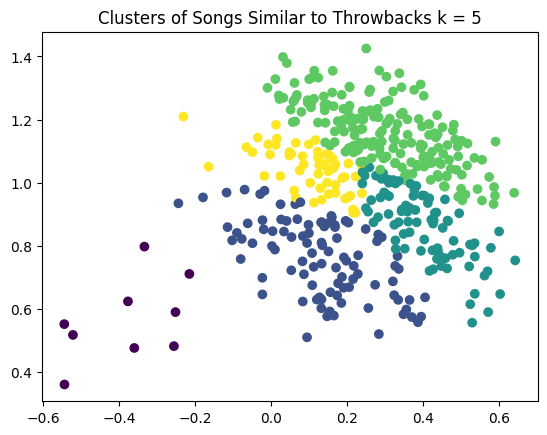

In [39]:
k_clusters = 5
pmi5, mu5, sig5, p5, d5 = GMM(dat2,k_clusters,dat2.shape[1])
plt.scatter(dat2.iloc[:, 0], dat2.iloc[:, 1], c=np.argmax(pmi5, axis=1))
plt.title(f'Clusters of Songs Similar to {df.iloc[input_playlist_idx]['name']} k = {k_clusters}')

In [40]:
get_top_k_songs(10, pmi5, dat, input_songs_indices)

,name,artists
348,Stay - Album Version (Edited),"['Rihanna', 'Mikky Ekko']"
340,The Climb,['Miley Cyrus']
254,Lord Knows,Drake
391,Aaron's Party (Come Get It),['Aaron Carter']
107,Hey There Delilah,Plain White T's
278,Chasing Cars,Snow Patrol
217,Rain Over Me,Pitbull
371,Pop,['*NSYNC']
235,I Will Follow You Into The Dark,Death Cab for Cutie
429,Apologize,NaN


In [41]:
# function to get recommendatios for any playlist, the above was an exmaple with at index 0 (Throwbacks playlist)
def get_recommendations(input_playlist_idx, k_playlists, k_songs, k_clusters):
    # get similarities from minhash
    similar = get_k_similar_playlists(Msig, input_playlist_idx, k_playlists)
    
    dat, input_songs_indices = process_similar_playlists(similar, input_playlist_idx)
    GMM_DROP = ['id', 'name', 'artists']
    dat1 = dat.drop(columns=GMM_DROP)
    dat2 = PCA(dat1, 2)
    # display(dat2)

    # run GMM to get clusters and recommendations from those clusters
    pmi, mu, sig, p, d = GMM(dat2, k_clusters, dat2.shape[1])
    plt.scatter(dat2.iloc[:, 0], dat2.iloc[:, 1], c=np.argmax(pmi, axis=1))
    plt.title(f'Cluster of Songs Similar {df.iloc[input_playlist_idx]['name']} k = {k_clusters}')
    recommendations = get_top_k_songs(k_songs, pmi, dat, input_songs_indices)
    
    return recommendations

Recommendations for korean 


,name,artists
140,We Are Bulletproof Pt.2,BTS
116,Not Today,BTS
91,She’s a Baby,Zico
217,Knock,Zion.T
320,Moving On,['BTS']
294,BTS Cypher Pt.2: Triptych,['BTS']
99,I Got This,Jay Park
309,WHISTLE - (Acoustic Ver.) KR Ver.,['BLACKPINK']
181,Twenty-three,IU
129,No More Dream,BTS


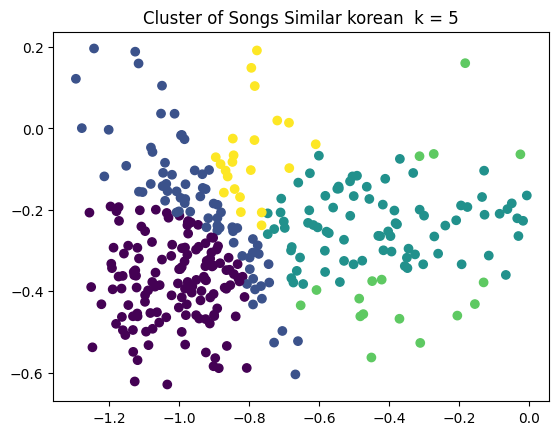

In [52]:
input_playlist_idx = 2
k_playlists = 20
k_songs = 10
k_clusters = 5

print('Recommendations for', df.iloc[input_playlist_idx]['name'])
get_recommendations(input_playlist_idx, k_playlists, k_songs, k_clusters)